# 04 – Variant Effects (In-Silico Saturation Mutagenesis)

This notebook computes **variant effects** for regulatory DNA by comparing the model’s prediction on a reference sequence vs. single-nucleotide mutants (A/C/G/T at each position).

**Inputs**: one-hot sequences `(N,L,4)` from processed splits or custom BED/FASTA slices.  
**Model**: trained linear-probe checkpoint from 03 (`results/probe_best.pt`).

**Outputs**:
- `results/vep/deltas_<split>.npz` with `deltas: (N,L,4)` (mutant − ref on chosen scale)
- `results/vep/summary.csv` with split-level stats
- Optional: per-position TSV + Top-K report

## 0) Environment & imports

In [79]:
import os, json, math, time, csv
from pathlib import Path
from typing import Dict, Tuple, List, Iterable, Optional

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


## 1) Paths & config

In [80]:
PROC = Path('data/processed')
RESULTS = Path('results'); RESULTS.mkdir(exist_ok=True, parents=True)
VEP = RESULTS / 'vep'; VEP.mkdir(exist_ok=True, parents=True)

# Model checkpoint from 03 (best linear probe)
CKPT_PATH = RESULTS / 'probe_best.pt'  # change if needed

# Which split to analyze; or later override with BED/FASTA utilities
SPLIT = 'test'  # 'train' | 'val' | 'test' | 'custom_bed' | 'custom_windows'

# Limit sequences for quick sweeps (None for full split)
MAX_SEQS = 8

# Run-time flags you may want to tweak quickly
SCALE = 'logit'   # 'logit' (default, smooth) or 'prob' (sigmoid probabilities)
POS_STEP = 1      # evaluate every k-th position (use >1 to speed up)
POS_CHUNK = None  # if set, process positions in chunks of this size to cap memory (e.g. 256)
BATCH = 256       # scoring batch size passed to deltas_for_sequence
K = 50            # Top-K sites to export in summary TSV
MASK_REF_IN_TSV = False  # if True, mask the ref-allele delta in per-position TSVs

## FASTA random access (pyfaidx preferred, `.fai` fallback)

In [81]:
try:
    from pyfaidx import Fasta as _PyFasta
    _HAVE_PYFAIDX = True
except Exception:
    _HAVE_PYFAIDX = False

_RC = str.maketrans(
    'ACGTRYMKBDHVNacgtrymkbdhvn',
    'TGCAYRKMVHDBNtgcayrkmvhdbn'
)

def revcomp(seq: str) -> str:
    return seq.translate(_RC)[::-1]

def load_fai_index(fai_path: Path) -> Dict[str, Tuple[int,int,int,int]]:
    idx = {}
    with open(fai_path, 'rt') as fh:
        for line in fh:
            if not line.strip():
                continue
            name, length, offset, line_bases, line_bytes = line.rstrip('\n').split('\t')[:5]
            idx[name] = (int(length), int(offset), int(line_bases), int(line_bytes))
    return idx

def _byte_offset(offset, line_bases, line_bytes, p):
    rows, col = divmod(p, line_bases)
    return offset + rows * line_bytes + col

def fetch_fasta_region(fa_path: Path, fai, chrom: str, start: int, end: int) -> str:
    if chrom not in fai:
        raise KeyError(f'Contig missing from index: {chrom}')
    chrom_len, offset, line_bases, line_bytes = fai[chrom]
    req_len = end - start
    pad_left  = max(0, -start)
    pad_right = max(0, end - chrom_len)
    start_c = max(0, start); end_c = min(chrom_len, end)
    if end_c <= start_c:
        return 'N' * req_len
    out = []
    with open(fa_path, 'rb') as fh:
        cur = start_c
        while cur < end_c:
            row = cur // line_bases
            col = cur % line_bases
            take = min(line_bases - col, end_c - cur)
            fh.seek(_byte_offset(offset, line_bases, line_bytes, cur))
            out.append(fh.read(take))
            cur += take
    seq = b''.join(out).decode('ascii').replace('\n','').replace('\r','')
    seq = ('N'*pad_left) + seq + ('N'*pad_right)
    if len(seq) != req_len:
        seq = (seq + 'N'*(req_len - len(seq)))[:req_len]
    return seq.upper()

class FastaAccessor:
    def __init__(self, fasta_path: str):
        self.fasta_path = Path(fasta_path)
        fai_path = self.fasta_path.with_suffix(self.fasta_path.suffix + '.fai')
        if _HAVE_PYFAIDX:
            self._fa = _PyFasta(str(self.fasta_path), as_raw=True, sequence_always_upper=True)
            self._mode = 'pyfaidx'
        else:
            if not fai_path.exists():
                raise FileNotFoundError(
                    f'Missing index {fai_path}. Install pyfaidx or run: samtools faidx {self.fasta_path}'
                )
            self._fai = load_fai_index(fai_path)
            self._mode = 'fai'
    def fetch(self, chrom: str, start: int, end: int, strand: str = '+') -> str:
        if self._mode == 'pyfaidx':
            seq = str(self._fa[chrom][start:end])
        else:
            seq = fetch_fasta_region(self.fasta_path, self._fai, chrom, start, end)
        return revcomp(seq) if strand == '-' else seq

## BED/FASTA → one-hot utilities (centered windows)

In [82]:
_NT2IDX = {'A':0,'C':1,'G':2,'T':3}
_IDX2NT = np.array(['A','C','G','T'])

def one_hot_from_seq(seq: str) -> np.ndarray:
    L = len(seq)
    arr = np.zeros((L,4), dtype=np.float32)
    for i,ch in enumerate(seq.upper()):
        j = _NT2IDX.get(ch, -1)
        if j >= 0:
            arr[i,j] = 1.0
    return arr

def center_window(start: int, end: int, L: int) -> Tuple[int,int]:
    mid = (start + end)//2
    half = L//2
    return mid - half, mid - half + L

def load_bed_to_onehot(bed_path: str, fasta_path: str, L: int,
                       assume_bed_0based: bool = True,
                       name_col: Optional[int] = 3,
                       score_col: Optional[int] = 4,
                       strand_col: Optional[int] = 5) -> Tuple[np.ndarray,np.ndarray,List[str]]:
    fa = FastaAccessor(fasta_path)
    X,y,names = [],[],[]
    with open(bed_path,'rt') as fh:
        for line in fh:
            if not line.strip() or line.startswith('#'):
                continue
            f = line.rstrip('\n').split('\t')
            chrom = f[0]; start = int(f[1]); end = int(f[2])
            if not assume_bed_0based:
                start = start - 1
            strand = '+'
            if strand_col is not None and len(f) > strand_col:
                strand = f[strand_col] if f[strand_col] in {'+','-'} else '+'
            win_s, win_e = center_window(start,end,L)
            seq = fa.fetch(chrom, win_s, win_e, strand=strand).upper()
            if len(seq) != L:
                seq = (seq + 'N'*(L - len(seq)))[:L]
            X.append(one_hot_from_seq(seq)); y.append(0)
            names.append(f'{chrom}:{win_s}-{win_e}({strand})')
    X = np.stack(X,axis=0) if X else np.zeros((0,L,4),dtype=np.float32)
    y = np.array(y,dtype=np.int64) if y else np.zeros((0,),dtype=np.int64)
    return X,y,names

def windows_to_onehot(fasta_path: str, windows: Iterable[Tuple[str,int,int,str]], L: int):
    fa = FastaAccessor(fasta_path)
    X,y,names = [],[],[]
    for chrom,start,end,strand in windows:
        win_s,win_e = center_window(start,end,L)
        seq = fa.fetch(chrom, win_s, win_e, strand=strand).upper()
        if len(seq) != L:
            seq = (seq + 'N'*(L-len(seq)))[:L]
        X.append(one_hot_from_seq(seq)); y.append(0)
        names.append(f'{chrom}:{win_s}-{win_e}({strand})')
    X = np.stack(X,axis=0) if X else np.zeros((0,L,4),dtype=np.float32)
    y = np.array(y,dtype=np.int64) if y else np.zeros((0,),dtype=np.int64)
    return X,y,names

## 2) Data loading (one-hot X, y)

In [83]:
class SequenceDataset(Dataset):
    def __init__(self, path: str):
        z = np.load(path, allow_pickle=True)
        if 'X' in z and 'y' in z:
            self.X, self.y = z['X'], z['y']
        else:
            raise ValueError(f'Expected X/y in {path}')
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return {'x': self.X[i], 'y': int(self.y[i])}

split_path = PROC / f'{SPLIT}.npz'
ds = SequenceDataset(str(split_path))
print('Loaded split:', SPLIT, 'size=', len(ds))
if MAX_SEQS is not None and len(ds) > MAX_SEQS:
    idx = np.arange(len(ds))[:MAX_SEQS]
    ds.X = ds.X[idx]; ds.y = ds.y[idx]
    print('Subsampled to', len(ds))

Loaded split: test size= 13
Subsampled to 8


### Safety checks

In [84]:
if not CKPT_PATH.exists():
    raise FileNotFoundError('Missing results/probe_best.pt. Train in 03 first, or update CKPT_PATH.')

if SPLIT in {'train','val','test'}:
    names_default = np.array([f'idx:{i}' for i in range(len(ds.X))], dtype=object)
    np.savez_compressed(VEP / f'names_{SPLIT}.npz', names=names_default)

## 3) Load model (linear probe; one-hot path)

In [85]:
class LinearProbe(nn.Module):
    def __init__(self, encoder_dim: int):
        super().__init__()
        self.classifier = nn.Linear(encoder_dim, 1)
        self.proj = nn.Linear(4, encoder_dim)  # one-hot → H
    def forward(self, embeddings: torch.Tensor):
        h = self.proj(embeddings)
        pooled = h.mean(dim=1)
        return self.classifier(pooled).squeeze(-1)

def infer_hidden_from_ckpt(sd: Dict[str, torch.Tensor]) -> int:
    for k,v in sd.items():
        if k.endswith('classifier.weight') and v.ndim==2:
            return v.shape[1]
    raise RuntimeError('Could not infer hidden size from checkpoint')

sd = torch.load(CKPT_PATH, map_location='cpu')
H = infer_hidden_from_ckpt(sd)
probe = LinearProbe(encoder_dim=H)
probe.load_state_dict(sd, strict=False)
probe.to(DEVICE).eval()
print('Loaded probe. Hidden dim =', H)

Loaded probe. Hidden dim = 128


## BED/FASTA integration (optional)

Notes: To drive VEP from a BED file set `USE_BED = True` and provide `BED_PATH` and `FASTA_PATH`.
The FASTA should either be accessible via `pyfaidx` or have a companion `.fai` index (run `samtools faidx ref.fa`).
BED is expected as 0-based half-open coordinates (chrom, start, end ...).
When `USE_BED` is used results and region names are saved under `results/vep/` and the run `SPLIT` is set to `'custom_bed'`.

In [86]:
USE_BED = False
BED_PATH = 'data/custom/regions.bed'
FASTA_PATH = 'reference.fa'

L_FIXED = ds.X.shape[1] if hasattr(ds,'X') and len(ds) else 2000

if USE_BED:
    print(f'Loading regions from BED: {BED_PATH}')
    X_bed, y_bed, names = load_bed_to_onehot(BED_PATH, FASTA_PATH, L=L_FIXED)
    print('BED → one-hot:', X_bed.shape)
    class _DS: pass
    ds = _DS(); ds.X, ds.y = X_bed, y_bed
    SPLIT = 'custom_bed'
    np.savez_compressed(VEP / 'custom_bed_names.npz', names=np.array(names, dtype=object))
    print('Saved region names to', VEP / 'custom_bed_names.npz')

# Manual windows example (uncomment to use)
# windows = [
#     ('chr1', 100_000, 100_200, '+'),
#     ('chr1', 200_000, 200_150, '-'),
# ]
# print(f'Loading regions from manual window list, count={len(windows)}')
# X_win, y_win, names = windows_to_onehot(FASTA_PATH, windows, L=L_FIXED)
# class _DS: pass
# ds = _DS(); ds.X, ds.y = X_win, y_win
# SPLIT = 'custom_windows'
# np.savez_compressed(VEP / 'custom_window_names.npz', names=np.array(names, dtype=object))

## 4) Scoring & saturation mutagenesis

In [87]:
@torch.no_grad()
def score_logits(x_onehot: np.ndarray) -> np.ndarray:
    x = torch.as_tensor(x_onehot, dtype=torch.float32, device=DEVICE)
    logits = probe(x)
    return logits.detach().cpu().numpy()

def logits_to_probs(logits: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-logits))

def deltas_for_sequence(x_onehot: np.ndarray, pos_step: int = 1, batch: int = 256, scale: str = 'logit', pos_chunk: Optional[int] = None) -> np.ndarray:
    """
    Compute per-position deltas (mutant - ref) on the requested scale ('logit' or 'prob').

    - pos_step>1 evaluates every k-th position (for speed).
    - pos_chunk: if set, positions are processed in chunks of this size to cap intermediate memory
      (each chunk produces chunk_size*4 mutants before batching). If None, all selected positions
      are prepared together (original behavior).

    Returns (L,4) with NaNs on skipped positions.
    """
    L = x_onehot.shape[0]
    ref_logit = score_logits(x_onehot[None, ...])[0]
    ref_val = logits_to_probs(ref_logit) if scale == 'prob' else ref_logit
    deltas = np.full((L,4), np.nan, dtype=np.float32)
    positions = np.arange(0, L, pos_step)
    ref_idx = x_onehot.argmax(axis=1)

    def _process_position_list(pos_list):
        muts = []
        order = []
        for i in pos_list:
            for alt in range(4):
                mut = x_onehot.copy()
                if alt != ref_idx[i]:
                    mut[i,:] = 0
                    mut[i,alt] = 1
                muts.append(mut)
                order.append((i,alt))
        if not muts:
            return
        muts_arr = np.stack(muts, axis=0)
        outs = []
        for s in range(0, len(muts_arr), batch):
            outs.append(score_logits(muts_arr[s:s+batch]))
        logits = np.concatenate(outs, axis=0)
        if scale == 'prob':
            probs = logits_to_probs(logits)
            for (i,alt), p in zip(order, probs):
                deltas[i,alt] = p - ref_val
        else:
            for (i,alt), logit in zip(order, logits):
                deltas[i,alt] = logit - ref_val

    if pos_chunk is None:
        _process_position_list(positions)
    else:
        for s in range(0, len(positions), pos_chunk):
            _process_position_list(positions[s:s+pos_chunk])

    return deltas


## 5) Run VEP and save outputs

In [88]:
X = ds.X  # (N,L,4)
N, L = X.shape[0], X.shape[1]
print(f'Running VEP on N={N} sequences, L={L}, scale={SCALE}, pos_step={POS_STEP}, pos_chunk={POS_CHUNK}, batch={BATCH}')

all_deltas = []
for i in range(N):
    # compute per-sequence deltas; use POS_CHUNK to limit intermediate memory if desired
    d = deltas_for_sequence(X[i], pos_step=POS_STEP, batch=BATCH, scale=SCALE, pos_chunk=POS_CHUNK)
    all_deltas.append(d)
all_deltas = np.stack(all_deltas, axis=0)

np.savez_compressed(VEP / f'deltas_{SPLIT}.npz', deltas=all_deltas)
print('Saved:', VEP / f'deltas_{SPLIT}.npz')

d_mean = float(np.nanmean(all_deltas))
d_abs_mean = float(np.nanmean(np.abs(all_deltas)))
summary_path = VEP / 'summary.csv'
write_header = not summary_path.exists()
with open(summary_path, 'a') as f:
    if write_header:
        f.write('split,N,L,scale,pos_step,pos_chunk,batch,delta_mean,delta_abs_mean\n')
    f.write(f'{SPLIT},{N},{L},{SCALE},{POS_STEP},{POS_CHUNK},{BATCH},{d_mean:.6f},{d_abs_mean:.6f}\n')
print('Summary written to', summary_path)

# Write a small run config snapshot for provenance
run_cfg = {
    'split': str(SPLIT),
    'N': int(N),
    'L': int(L),
    'ckpt': str(CKPT_PATH.name),
    'scale': str(SCALE),
    'pos_step': int(POS_STEP) if POS_STEP is not None else None,
    'pos_chunk': int(POS_CHUNK) if POS_CHUNK is not None else None,
    'batch': int(BATCH),
    'K': int(K),
    'date': time.strftime('%Y-%m-%dT%H:%M:%SZ', time.gmtime())
}
with open(VEP / 'run_config.json', 'w') as fh:
    json.dump(run_cfg, fh, indent=2)
print('Wrote run config to', VEP / 'run_config.json')

# Quick QC: ensure ref-allele deltas are (near) zero on average
try:
    ref_means = []
    for i in range(all_deltas.shape[0]):
        ref_idx = ds.X[i].argmax(axis=1)
        ref_vals = all_deltas[i, np.arange(all_deltas.shape[1]), ref_idx]
        ref_means.append(float(np.nanmean(np.abs(ref_vals))))
    overall_ref_mean = float(np.nanmean(ref_means))
    print(f'QC: mean abs delta at ref alleles (across sequences) = {overall_ref_mean:.6e}')
    if overall_ref_mean > 1e-5:
        print('Warning: reference-allele deltas are unexpectedly large; check implementation or numerical issues')
except Exception as e:
    print('QC check failed:', e)

Running VEP on N=8 sequences, L=2000, scale=logit, pos_step=1, pos_chunk=None, batch=256
Saved: results/vep/deltas_test.npz
Summary written to results/vep/summary.csv
Wrote run config to results/vep/run_config.json
QC: mean abs delta at ref alleles (across sequences) = 0.000000e+00
Saved: results/vep/deltas_test.npz
Summary written to results/vep/summary.csv
Wrote run config to results/vep/run_config.json
QC: mean abs delta at ref alleles (across sequences) = 0.000000e+00


### Exports: per-position TSV and Top-K sites

In [89]:
def write_per_position_tsv(path: Path, deltas: np.ndarray, names=None, mask_ref: bool = False):
    """Write per-position TSV. If mask_ref=True, zero-valued allele deltas (the reference
    allele slot) are written as empty strings to focus on true substitutions."""
    N,L,_ = deltas.shape
    with open(path, 'w', newline='') as f:
        w = csv.writer(f, delimiter='\t')
        w.writerow(['record','pos','dA','dC','dG','dT','max_abs','argmax'])
        for n in range(N):
            rec = names[n] if (names is not None and n < len(names)) else f'idx:{n}'
            for i in range(L):
                dA,dC,dG,dT = deltas[n,i]
                vals = [dA,dC,dG,dT]
                row_vals = []
                for v in vals:
                    if mask_ref and np.isclose(v, 0.0, atol=0.0):
                        row_vals.append('')
                    else:
                        row_vals.append(f'{v:.6f}')
                row = [rec, i] + row_vals
                arr = np.array([dA,dC,dG,dT], dtype=np.float32)
                m = float(np.nanmax(np.abs(arr)))
                arg = ['A','C','G','T'][int(np.nanargmax(np.abs(arr)))]
                w.writerow(row + [f'{m:.6f}', arg])

# resolve names npz
if SPLIT == 'custom_bed':
    names_npz = VEP / 'custom_bed_names.npz'
elif SPLIT == 'custom_windows':
    names_npz = VEP / 'custom_window_names.npz'
else:
    names_npz = VEP / f'names_{SPLIT}.npz'

names = None
if names_npz.exists():
    names = np.load(names_npz, allow_pickle=True)['names']

tsv_path = VEP / f'deltas_{SPLIT}.tsv'
write_per_position_tsv(tsv_path, all_deltas, names=names, mask_ref=MASK_REF_IN_TSV)
print('Per-position TSV written to', tsv_path)

# Top-K summary (K comes from the configuration area above)
# K is already defined in the config cell

flat = []
for n in range(all_deltas.shape[0]):
    arr = np.abs(all_deltas[n])
    vals = arr.max(axis=1)
    for i, v in enumerate(vals):
        flat.append((float(v), n, i))
flat.sort(reverse=True)
topk = flat[:K]
topk_path = VEP / f'top{K}_{SPLIT}.tsv'
with open(topk_path, 'w', newline='') as f:
    w = csv.writer(f, delimiter='\t')
    w.writerow(['rank','record','pos','max_abs_delta'])
    for r, (v, n, i) in enumerate(topk, 1):
        rec = names[n] if names is not None else f'idx:{n}'
        w.writerow([r, rec, i, f'{v:.6f}'])
print(f'Top-{K} summary written to', topk_path)

Per-position TSV written to results/vep/deltas_test.tsv
Top-50 summary written to results/vep/top50_test.tsv


## 6) Plot a position-wise delta map for one example

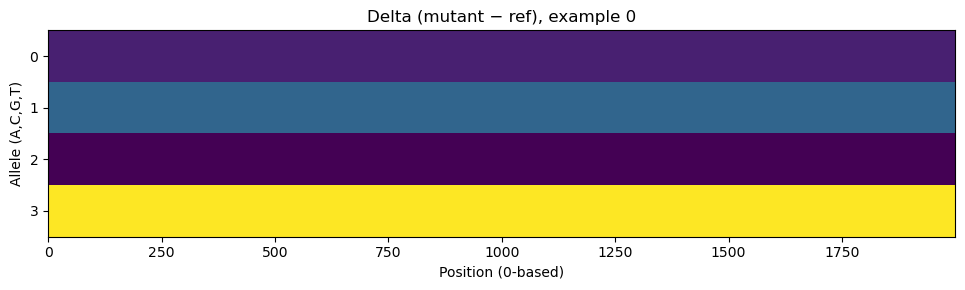

In [90]:
ex = 0  # change to visualize other sequences
if hasattr(ds,'X') and len(ds.X):
    d = np.load(VEP / f'deltas_{SPLIT}.npz')['deltas'][ex]
    plt.figure(figsize=(10,3))
    plt.imshow(d.T, aspect='auto', interpolation='nearest')
    plt.xlabel('Position (0-based)')
    plt.ylabel('Allele (A,C,G,T)')
    plt.title(f'Delta (mutant − ref), example {ex}')
    plt.tight_layout(); plt.show()
else:
    print('No sequences to plot.')